Just a reader-friendly version of isolate.ipynb

## Initial Cuts

In [1]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline
path = '/Users/chris/Desktop/sculpting/berger_gaia_kepler/'
# all data downloaded from Berger et al 2020's ancillary tables: https://arxiv.org/src/2001.07737v3/anc
# the paper we're comparing against: https://arxiv.org/pdf/2005.14671.pdf
# command line edit to get rid of double backslashes at end of each row: sed -e "s/\\\//g" GKSPCPapTable2_Final.txt > GKSPCPapTable2_cleaned.txt
table2 = pd.read_csv(path+'GKSPCPapTable2_cleaned.txt', sep='&', header=0)
print(len(table2))
print(table2.head())
print(table2.columns)

186301
      KIC  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  iso_teff_err1  \
0  757076     1.396          0.179         -0.218    5052.2          103.9   
1  757099     0.873          0.054         -0.039    5364.9          102.7   
2  757137     1.669          0.309         -0.300    4628.7           84.8   
3  757280     1.715          0.086         -0.089    6856.8          144.4   
4  757450     0.914          0.062         -0.057    5301.2          111.0   

   iso_teff_err2  iso_logg  iso_logg_err1  iso_logg_err2  ...  iso_age  \
0          -86.6     3.373          0.067         -0.081  ...     2.47   
1          -84.9     4.318          0.037         -0.029  ...    15.20   
2          -76.2     2.388          0.083         -0.086  ...     1.51   
3         -139.9     3.834          0.033         -0.032  ...     1.24   
4         -103.1     4.432          0.045         -0.044  ...     9.46   

   unReAgeFlag  iso_age_err1  iso_age_err2  iso_dis  iso_dis_err1  \
0         

In [2]:
# remove stars with unreliable ages or bad goodness of fit
table2 = table2.loc[(table2.unReAgeFlag.isnull()) & (table2.iso_gof==1.)]
print(len(table2))

150560


In [3]:
# remove stars with uninformative posteriors (per paper, terminal age of main sequence > 20 Gyr)
table2 = table2.loc[table2['TAMS']<=20]
print(len(table2))
# nice to see that tracks with bad gof or unreliable age

150560


In [4]:
# remove stars beyond [3700, 7500] K Teff, ie. keep only FGK stars
fgk = table2.loc[(table2['iso_teff'] <= 7500) & (table2['iso_teff'] >= 3700)]
print(len(fgk))

147900


In [5]:
# introduce Table 1 to use RUWE (re-normalized unit-weight error), aka binary star/edge-of-parameter space classifier
# command line edit to get rid of double backslashes at end of each row: sed -e "s/\\\//g" GKSPCPapTable1_Final.txt > GKSPCPapTable1_cleaned.txt
table1 = pd.read_csv(path+'GKSPCPapTable1_cleaned.txt', sep='&', header=0)
table1 = table1.loc[table1.RUWE<=1.2]
print(len(table1))
print(table1.head())
print(table1.columns)

164740
      KIC     gmag  gmag_err    kmag  kmag_err  parallax  parallax_err    feh  \
0  757076  12.3510    0.0203   9.559     0.017    1.5239        0.0483    NaN   
2  757137  10.0523    0.0279   6.722     0.017    1.7534        0.0253    NaN   
3  757280  12.1329    0.0200  10.627     0.018    1.2137        0.0220    NaN   
4  757450  15.8950    0.0202  13.118     0.029    1.1989        0.0261  0.229   
7  892010  12.6168    0.0209   9.041     0.017    0.5414        0.0242    NaN   

   feh_err    RUWE  num_gaia_companions Kmag_final_prov evstate  
0      NaN  0.9467                    0             NaN     NaN  
2      NaN  0.9126                    0             NaN     RGB  
3      NaN  0.8704                    0             NaN     NaN  
4     0.15  1.0300                    0             NaN     NaN  
7      NaN  1.0141                    0             NaN     NaN  
Index(['KIC', 'gmag', 'gmag_err', 'kmag', 'kmag_err', 'parallax',
       'parallax_err', 'feh', 'feh_err', 'RU

In [6]:
# join tables
catalog = pd.merge(fgk, table1, how='inner', on='KIC')
print(catalog.head())
print(len(catalog))

      KIC  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  iso_teff_err1  \
0  757076     1.396          0.179         -0.218    5052.2          103.9   
1  757137     1.669          0.309         -0.300    4628.7           84.8   
2  757280     1.715          0.086         -0.089    6856.8          144.4   
3  757450     0.914          0.062         -0.057    5301.2          111.0   
4  892010     1.710          0.708         -0.402    4555.8          141.3   

   iso_teff_err2  iso_logg  iso_logg_err1  iso_logg_err2  ...    kmag  \
0          -86.6     3.373          0.067         -0.081  ...   9.559   
1          -76.2     2.388          0.083         -0.086  ...   6.722   
2         -139.9     3.834          0.033         -0.032  ...  10.627   
3         -103.1     4.432          0.045         -0.044  ...  13.118   
4          -92.4     2.299          0.163         -0.119  ...   9.041   

   kmag_err  parallax  parallax_err    feh  feh_err    RUWE  \
0     0.017    1.5239        

In [7]:
# isolate giant stars
# using unnumbered equation in first paragraph of Sec 4.2.1 ("Sample Selection") in Berger et al 2020b 
catalog['logR'] = np.log10(catalog.iso_rad)
catalog['is_giant'] = np.where(catalog['logR'] >= 0.00035*(catalog['iso_teff'] - 4500) + 0.15, True, False)
catalog = catalog.loc[catalog['is_giant'] == False]
print(len(catalog))
print(catalog.head())

112397
      KIC  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  iso_teff_err1  \
2  757280     1.715          0.086         -0.089    6856.8          144.4   
3  757450     0.914          0.062         -0.057    5301.2          111.0   
6  892195     0.862          0.057         -0.040    5333.4          101.3   
7  892667     1.548          0.081         -0.087    6704.9          148.8   
8  892675     1.038          0.066         -0.076    5929.4          108.9   

   iso_teff_err2  iso_logg  iso_logg_err1  iso_logg_err2  ...  parallax  \
2         -139.9     3.834          0.033         -0.032  ...    1.2137   
3         -103.1     4.432          0.045         -0.044  ...    1.1989   
6          -84.2     4.372          0.039         -0.029  ...    2.0802   
7         -128.8     3.950          0.034         -0.036  ...    0.8512   
8         -108.1     4.385          0.035         -0.043  ...    1.7114   

   parallax_err    feh  feh_err    RUWE  num_gaia_companions  Kmag_final_

In [8]:
# get rid of stars with age errors greater than 1 Gyr
print(len(catalog))
catalog = catalog.loc[np.abs(catalog.iso_age_err1) < 1.]
catalog = catalog.loc[np.abs(catalog.iso_age_err2) < 1.]
print(len(catalog))

112397
19969


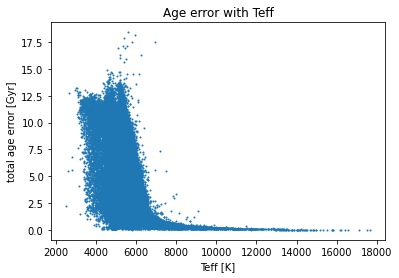

In [22]:
# plot emailed to Matthias He on 11/27/21 to explain discrepancy in our higher-multiplicity bins
plt.scatter(table2.iso_teff, np.abs(table2.iso_age_err1)+np.abs(table2.iso_age_err2), s=1)
plt.xlabel('Teff [K]')
plt.ylabel('total age error [Gyr]')
plt.title('Age error with Teff')
#plt.ylim(0, 1000)
plt.show()

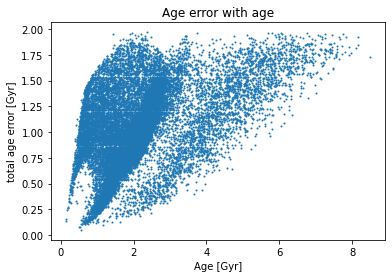

In [23]:
# plot emailed to Matthias He on 11/27/21 to explain discrepancy in our higher-multiplicity bins
plt.scatter(catalog.iso_age, np.abs(catalog.iso_age_err1)+np.abs(catalog.iso_age_err2), s=1)
plt.xlabel('Age [Gyr]')
plt.ylabel('total age error [Gyr]')
plt.title('Age error with age')
#plt.ylim(0, 1000)
plt.show()

Berger et al age distribution

[ 409 1918 2978 3679 3709 2930 1248  638  469  431  369  348  290  211
  153   85   53   38    9    4]
[0.14   0.5575 0.975  1.3925 1.81   2.2275 2.645  3.0625 3.48   3.8975
 4.315  4.7325 5.15   5.5675 5.985  6.4025 6.82   7.2375 7.655  8.0725
 8.49  ]


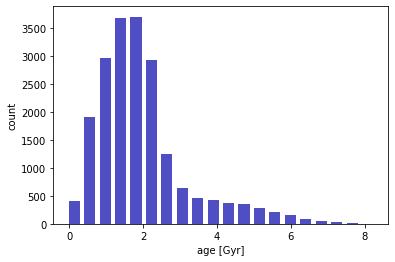

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

# age histogram for all stars with well-constrained ages 
age_hist, age_bin_edges = np.histogram(catalog.iso_age, bins=20)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.3, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

### Cross matching with KOIs from Exoplanet archive

In [10]:
# source: https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative
path = '/Users/chris/Desktop/sculpting/crossmatch_fun/'
kois = pd.read_csv(path+'cumulative_2021.03.04_20.04.43.csv')
kois = kois.loc[kois.koi_disposition != 'FALSE POSITIVE']
print(kois)
print(list(kois.columns))

         kepid kepoi_name   kepler_name koi_disposition koi_pdisposition  \
0     10797460  K00752.01  Kepler-227 b       CONFIRMED        CANDIDATE   
1     10797460  K00752.02  Kepler-227 c       CONFIRMED        CANDIDATE   
2     10811496  K00753.01           NaN       CANDIDATE        CANDIDATE   
4     10854555  K00755.01  Kepler-664 b       CONFIRMED        CANDIDATE   
5     10872983  K00756.01  Kepler-228 d       CONFIRMED        CANDIDATE   
...        ...        ...           ...             ...              ...   
9538   9938836  K07978.01           NaN       CANDIDATE        CANDIDATE   
9542  10011213  K07982.01           NaN       CANDIDATE        CANDIDATE   
9552  10028127  K08193.01           NaN       CANDIDATE        CANDIDATE   
9560  10128825  K07986.01           NaN       CANDIDATE        CANDIDATE   
9562  10155286  K07988.01           NaN       CANDIDATE        CANDIDATE   

      koi_score  koi_fpflag_nt  koi_fpflag_ss  koi_fpflag_co  koi_fpflag_ec  \
0       

In [21]:
combined2 = pd.merge(catalog, kois, how='inner', left_on='kepoi_name', right_on='kepid') 
combined2.kepoi_name

0      K01001.01
1      K01001.02
2      K02403.01
3      K02610.01
4      K02610.02
         ...    
402    K03122.01
403    K04329.01
404    K08082.01
405    K05977.01
406    K04245.01
Name: kepoi_name, Length: 407, dtype: object

In [28]:
combined.loc[combined.kepoi_name == 'K02770.01']

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag


In [11]:
combined = pd.merge(catalog, kois, how='inner', left_on='KIC', right_on='kepid') 
print(len(kois))
print(len(catalog))
print(len(combined))
print(combined.head())
print(combined.columns)

4724
19969
407
       KIC  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  iso_teff_err1  \
0  1871056     1.426          0.065         -0.074    6215.7          124.7   
1  1871056     1.426          0.065         -0.074    6215.7          124.7   
2  2142522     1.205          0.032         -0.044    6319.1          110.1   
3  2305866     1.552          0.079         -0.077    6541.5          135.2   
4  2305866     1.552          0.079         -0.077    6541.5          135.2   

   iso_teff_err2  iso_logg  iso_logg_err1  iso_logg_err2  ...  koi_steff_err2  \
0         -116.2     3.985          0.031         -0.033  ...          -125.0   
1         -116.2     3.985          0.031         -0.033  ...          -125.0   
2         -101.0     4.373          0.017         -0.022  ...          -147.0   
3         -128.2     3.900          0.032         -0.031  ...          -250.0   
4         -128.2     3.900          0.032         -0.031  ...          -250.0   

   koi_slogg  koi_slogg

Okay, this leads to the same number of planets (+/- 1) as the Berger+Bedell way. Let's stick with isolate_with_bedell.ipynb

## Ignore below

In [14]:
# cross-matching from Megan Bedell's gaia-kepler.fun KIC objs
path = '/Users/chris/Desktop/sculpting/crossmatch_fun/'
hdu1 = fits.open(path+'kepler_dr2_1arcsec.fits')
data = hdu1[1].data
header = hdu1[1].header
columns = hdu1[1].columns
hdu1.close()

In [ ]:
print(len(data[0]))
print(data[0])
print(len(columns))
print(columns)

In [15]:
# let's read into pandas table instead
###kep_data = Table.read(path+'kepler_dr2_1arcsec.fits', format='fits')
###kep_data = kep_data.to_pandas() --> TypeError: data type '>I2' not understood
### decode byte literal column to string
###kep_data['planet?'] = kep_data['planet?'].str.decode("utf-8")

with fits.open(path+'kepler_dr2_1arcsec.fits') as kep_data:
    kep_data = pd.DataFrame(kep_data[1].data)
    
kep_data_thin = kep_data[['kepid','planet?']]
print(kep_data_thin.head())

    kepid planet?
0  757076    none
1  757099    none
2  757137    none
3  757280    none
4  757450    conf


In [16]:
# join Bedell cross-match with Berger catalog
crossmatch = pd.merge(catalog, kep_data, how='inner', left_on='KIC', right_on='kepid')
print(len(catalog))
print(len(kep_data))
print(len(crossmatch))
print(crossmatch.head())

19969
201312
19995
      KIC  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  iso_teff_err1  \
0  757280     1.715          0.086         -0.089    6856.8          144.4   
1  892667     1.548          0.081         -0.087    6704.9          148.8   
2  892678     1.584          0.071         -0.062    5890.4          121.6   
3  892713     1.731          0.219         -0.087    6238.9          123.4   
4  892828     1.398          0.071         -0.069    6464.3          137.7   

   iso_teff_err2  iso_logg  iso_logg_err1  iso_logg_err2  ...  mass_err2  \
0         -139.9     3.834          0.033         -0.032  ...     -0.157   
1         -128.8     3.950          0.034         -0.036  ...     -0.236   
2         -114.9     3.574          0.030         -0.030  ...     -0.204   
3         -129.8     3.548          0.066         -0.037  ...     -0.270   
4         -128.9     4.034          0.032         -0.034  ...     -0.217   

   prov_sec  nconfp  nkoi  ntce    jmag    hmag  kmag_y

In [77]:
list(crossmatch.columns)

['KIC',
 'iso_mass',
 'iso_mass_err1',
 'iso_mass_err2',
 'iso_teff',
 'iso_teff_err1',
 'iso_teff_err2',
 'iso_logg',
 'iso_logg_err1',
 'iso_logg_err2',
 'iso_feh',
 'iso_feh_err1',
 'iso_feh_err2',
 'iso_rad',
 'iso_rad_err1',
 'iso_rad_err2',
 'iso_rho',
 'iso_rho_err1',
 'iso_rho_err2',
 'iso_lum',
 'iso_lum_err1',
 'iso_lum_err2',
 'iso_age',
 'unReAgeFlag',
 'iso_age_err1',
 'iso_age_err2',
 'iso_dis',
 'iso_dis_err1',
 'iso_dis_err2',
 'iso_avs',
 'iso_gof',
 'TAMS',
 'gmag',
 'gmag_err',
 'kmag_x',
 'kmag_err',
 'parallax_x',
 'parallax_err',
 'feh_x',
 'feh_err',
 'RUWE',
 'num_gaia_companions',
 'Kmag_final_prov',
 'evstate',
 'logR',
 'is_giant',
 'solution_id',
 'designation',
 'source_id',
 'random_index',
 'gaia_ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax_y',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_p

In [79]:
# could we get planet multiplicity from KIC duplicates?
print(len(crossmatch))
crossmatch['dupe_label'] = crossmatch.duplicated(subset=['kepid'], keep=False)
print(crossmatch.loc[crossmatch.dupe_label == True])
print(list(crossmatch.loc[crossmatch.dupe_label == True].kepid))
# no.

19995
            KIC  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  ...  \
77      1573954     1.484          0.096         -0.087    6932.7  ...   
78      1573954     1.484          0.096         -0.087    6932.7  ...   
941     3129842     1.224          0.070         -0.077    6871.4  ...   
942     3129842     1.224          0.070         -0.077    6871.4  ...   
2014    3866583     1.684          0.095         -0.120    6476.7  ...   
...         ...       ...            ...            ...       ...  ...   
17612  10879850     1.447          0.063         -0.121    6182.3  ...   
18669  11506988     1.487          0.061         -0.145    6559.3  ...   
18670  11506988     1.487          0.061         -0.145    6559.3  ...   
18826  11607521     1.826          0.199         -0.193    6619.2  ...   
18827  11607521     1.826          0.199         -0.193    6619.2  ...   

         hmag  kmag_y  planet?  kepler_gaia_ang_dist  dupe_label  
77     13.442  13.470     none        

Chose 1" search radius Kepler data upon consultation with Megan Bedell. Also, see full isolate.ipynb under noodling/ directory where I replicate with 20" search radius data, as well as K2 data.

In [17]:
# use 1" search radius Kepler data

# drop duplicates on KIC, which we can do because we guaranteed one-to-one matching of KIC and planet-occurrence status
group_crossmatch = crossmatch.drop_duplicates(['KIC'])
print(len(crossmatch))
print(len(group_crossmatch))

# count Kepler objects with each type of planet occurrence
none = group_crossmatch.loc[group_crossmatch['planet?'] == 'none']
cand = group_crossmatch.loc[group_crossmatch['planet?'] == 'cand']
conf = group_crossmatch.loc[group_crossmatch['planet?'] == 'conf']
print(len(none))
print(len(cand))
print(len(conf))

# cand and conf planet occurrence rates across FGK dwarfs from Berger et al 2020
print("candidates only: ", len(cand)/len(group_crossmatch))
print("confirmed only: ", len(conf)/len(group_crossmatch))
print("candidates and confirmed: ", (len(cand)+len(conf))/len(group_crossmatch))

19995
19939
18959
864
116
candidates only:  0.04333216309744722
confirmed only:  0.005817744119564672
candidates and confirmed:  0.04914990721701189


In [81]:
# let's keep both confirmed and candidate planets
pos = crossmatch.loc[crossmatch['planet?'] != 'none']
print(len(pos))
pos['dupe_label'] = pos.duplicated(subset=['kepid'], keep=False)
print(pos.loc[pos.dupe_label == True])


983
            KIC  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  ...  \
10883   8046659     1.189          0.066         -0.081    6847.6  ...   
10884   8046659     1.189          0.066         -0.081    6847.6  ...   
13760   9116510     1.152          0.049         -0.042    6691.2  ...   
13761   9116510     1.152          0.049         -0.042    6691.2  ...   
16251  10155080     1.250          0.070         -0.068    5843.9  ...   
16252  10155080     1.250          0.070         -0.068    5843.9  ...   

         hmag  kmag_y  planet?  kepler_gaia_ang_dist  dupe_label  
10883  13.491  13.523     cand              0.715064        True  
10884  13.491  13.523     cand              0.897246        True  
13760  12.772  12.716     cand              0.679795        True  
13761  12.772  12.716     cand              0.781874        True  
16251  11.651  11.627     cand              0.543404        True  
16252  11.651  11.627     cand              0.605712        True  

[6 rows

I also do this with all well-defined stars (ie. beyond just FGK) from Berger et al in the full isolate.ipynb notebook. But we'll move forward with only FGK stars here.

### Joining Kepler cross-match with Exoplanets archive dataset

In [99]:
# check that pl_pnums > 1 come from the same star
print(positives_kepler[['iso_mass', 'mass', 'iso_teff', 'teff', 'iso_rad',
                        'radius', 'iso_age', 'koi_count', 'planet?']].head(n=20))
# 'st_metfe', 'gmag', 'st_optmag', 'kmag',

    iso_mass   mass  iso_teff  teff  iso_rad  radius  iso_age  koi_count  \
0      1.515  1.449    6436.5  6440    1.995   1.952     1.74          1   
1      1.264  1.132    6365.3  6225    1.545   1.451     2.62          1   
2      1.375  1.193    6240.4  6270    1.875   1.286     2.51          1   
3      1.437  1.386    6943.4  6823    1.491   1.367     0.69          1   
4      1.301  1.279    6366.1  6520    1.589   1.215     2.44          1   
..       ...    ...       ...   ...      ...     ...      ...        ...   
15     1.529  1.202    6026.5  5884    2.735   1.426     2.29          1   
16     1.329  2.736    6678.3  5313    1.545   9.327     1.76          2   
17     1.329  2.736    6678.3  5313    1.545   9.327     1.76          2   
18     1.452  1.304    6998.9  6490    1.607   1.307     1.08          1   
19     1.417  1.399    6951.9  6306    1.661   1.792     1.44          1   

   planet?  
0     conf  
1     conf  
2     cand  
3     conf  
4     cand  
..     ..

### Joining Kepler cross-match with separate Bedell exoplanets dataset

Hmm, the exoplanets dataset has multiplicities for confirmed planets, but let's see if this works with candidates as well.

In [26]:
#import warnings
#warnings.filterwarnings('ignore')
path = '/Users/chris/Desktop/sculpting/crossmatch_fun/'

with fits.open(path+'exoplanets_dr2_1arcsec.fits') as positives:
    positives = pd.DataFrame(positives[1].data)

print(positives.head())
#positives = Table.read(path+'exoplanets_dr2_1arcsec.fits', format='fits')
#print(positives)
#positives = positives.to_pandas()
#print(positives.head())

           solution_id                   designation            source_id  \
0  1635721458409799680  Gaia DR2 3946945413106333696  3946945413106333696   
1  1635721458409799680  Gaia DR2 1696798367260229376  1696798367260229376   
2  1635721458409799680  Gaia DR2 1920113512486282240  1920113512486282240   
3  1635721458409799680  Gaia DR2 1385293808145621504  1385293808145621504   
4  1635721458409799680  Gaia DR2 2135550755683407232  2135550755683407232   

   random_index  gaia_ref_epoch          ra  ra_error        dec  dec_error  \
0     221573267          2015.5  185.178779  0.162032  17.793252   0.131688   
1      91495763          2015.5  229.274595  0.122354  71.823943   0.110681   
2     162105136          2015.5  352.824150  0.106518  39.235837   0.074691   
3    1155875906          2015.5  242.602101  0.019262  43.816362   0.019824   
4     166057510          2015.5  295.465642  0.022583  50.516824   0.024786   

    parallax  ...  pl_cbflag  pl_disc    hd_name    hip_name  

In [59]:
positives_kepler.loc[positives_kepler['planet?'] == 'cand']

,solution_id_x,designation_x,source_id,random_index_x,gaia_ref_epoch_x,...,jmag,hmag,kmag,planet?,kepler_gaia_ang_dist


Uh oh...looks like the exoplanets dataset only includes confirmed planets. Do we even need this dataset, though? Can I get planet counts by just, y'know, counting?

In [47]:
len(pos.duplicated(keep=False))

980

In [56]:
print(list(pos.columns))

['KIC', 'iso_mass', 'iso_mass_err1', 'iso_mass_err2', 'iso_teff', 'iso_teff_err1', 'iso_teff_err2', 'iso_logg', 'iso_logg_err1', 'iso_logg_err2', 'iso_feh', 'iso_feh_err1', 'iso_feh_err2', 'iso_rad', 'iso_rad_err1', 'iso_rad_err2', 'iso_rho', 'iso_rho_err1', 'iso_rho_err2', 'iso_lum', 'iso_lum_err1', 'iso_lum_err2', 'iso_age', 'unReAgeFlag', 'iso_age_err1', 'iso_age_err2', 'iso_dis', 'iso_dis_err1', 'iso_dis_err2', 'iso_avs', 'iso_gof', 'TAMS', 'gmag', 'gmag_err', 'kmag_x', 'kmag_err', 'parallax_x', 'parallax_err', 'feh_x', 'feh_err', 'RUWE', 'num_gaia_companions', 'Kmag_final_prov', 'evstate', 'logR', 'is_giant', 'solution_id', 'designation', 'source_id', 'random_index', 'gaia_ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax_y', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_

In [62]:
# the only columns I need to keep
pos[['iso_mass', 'mass', 'iso_teff', 'teff', 'iso_rad',
                        'radius', 'iso_age', 'planet?']]

,iso_mass,mass,iso_teff,teff,iso_rad,radius,iso_age,planet?
7,1.374,0.796,6103.8,5951,2.252,0.702,2.93,cand
16,1.497,1.358,6265.1,6443,1.994,1.448,1.98,cand
22,1.744,2.050,6635.0,6341,2.872,5.302,1.29,cand
32,1.243,1.200,5568.0,6233,2.488,1.921,3.84,cand
38,1.434,1.500,6535.1,6570,1.748,2.270,1.73,cand
...,...,...,...,...,...,...,...,...
19933,1.448,1.596,7021.4,6787,1.579,2.753,1.01,cand
19960,1.394,1.238,6790.5,6782,1.745,1.379,1.78,cand
19963,1.485,1.474,6804.9,6596,1.806,1.721,1.41,cand
19971,1.478,1.249,6166.4,6059,2.113,1.554,2.26,cand


In [61]:
kep_data[['iso_mass', 'mass', 'iso_teff', 'teff', 'iso_rad',
                        'radius', 'iso_age', 'planet?']]

KeyError: "['iso_teff', 'iso_rad', 'iso_age', 'iso_mass'] not in index"

In [63]:
pd.merge(kep_data, pos, how='inner', on='source_id')

,solution_id_x,designation_x,source_id,random_index_x,gaia_ref_epoch_x,...,jmag_y,hmag_y,kmag_y,planet?_y,kepler_gaia_ang_dist_y
0,1635721458409799680,Gaia DR2 2050236727912831872,2050236727912831872,1243639930,2015.5,...,13.609,13.298,13.277,cand,0.108526
1,1635721458409799680,Gaia DR2 2050243909098361856,2050243909098361856,641766488,2015.5,...,12.927,12.724,12.659,cand,0.059701
2,1635721458409799680,Gaia DR2 2050256416043021696,2050256416043021696,68766862,2015.5,...,11.753,11.533,11.497,cand,0.038394
3,1635721458409799680,Gaia DR2 2051688529935082880,2051688529935082880,416593511,2015.5,...,12.345,11.987,11.879,cand,0.055981
4,1635721458409799680,Gaia DR2 2051012295923656704,2051012295923656704,312039869,2015.5,...,12.230,12.032,11.980,cand,0.081720
...,...,...,...,...,...,...,...,...,...,...,...
975,1635721458409799680,Gaia DR2 2139222639185477248,2139222639185477248,715084713,2015.5,...,11.530,11.362,11.296,cand,0.105906
976,1635721458409799680,Gaia DR2 2139298063108091008,2139298063108091008,844375697,2015.5,...,12.899,12.718,12.680,cand,0.047167
977,1635721458409799680,Gaia DR2 2139241880640247424,2139241880640247424,887176051,2015.5,...,12.654,12.504,12.438,cand,0.037813
978,1635721458409799680,Gaia DR2 2139267135047224960,2139267135047224960,924757225,2015.5,...,12.449,12.197,12.159,cand,0.185530


In [69]:
crossmatch_pos = crossmatch.loc[crossmatch['planet?'] != 'none']
print(len(crossmatch_pos))
print(len(crossmatch_pos.source_id.unique()))
print(len(pd.merge(kep_data, pos, how='inner', on='source_id').source_id.unique()))

983
983
980


### CDPP

Characterize the noise between young and old stars with multiple CDPPs. Data from http://archive.stsci.edu/pub/kepler/catalogs/

In [33]:
path = '/Users/chris/Desktop/sculpting/crossmatch_fun/'
kepler_stellar = pd.read_csv(path+'kepler_stellar_17.csv')
print(len(kepler_stellar))
print(kepler_stellar.head())

200038
    kepid           tm_designation  teff  teff_err1  teff_err2   logg  \
0  757076  2MASS J19240929+3635532  5160      171.0     -156.0  3.580   
1  757099  2MASS J19241033+3635377  5519      182.0     -149.0  3.822   
2  757137  2MASS J19241341+3633358  4706       74.0     -102.0  2.374   
3  757280  2MASS J19242289+3633538  6543      162.0     -194.0  4.082   
4  757450  2MASS J19243302+3634385  5332      106.0      -96.0  4.500   

   logg_err1  logg_err2   feh  feh_err1  ...  timeout06p0  timeout07p5  \
0      0.928     -0.232 -0.10      0.30  ...          0.0          0.0   
1      0.638     -0.213 -0.22      0.35  ...          1.0          1.0   
2      0.030     -0.027 -0.10      0.20  ...          1.0          1.0   
3      0.258     -0.172 -0.24      0.25  ...          0.0          0.0   
4      0.050     -0.036 -0.08      0.15  ...          0.0          0.0   

   timeout09p0  timeout10p5  timeout12p0  timeout12p5  timeout15p0  \
0          0.0          0.0          0.